In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

Obtain the stock market data using yfinance, we are using the S&P 500 Index in this case

In [10]:
GSPC = yf.Ticker('^GSPC')
GSPC.info

{'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 6370.17,
 'open': 6384.59,
 'dayLow': 6384.59,
 'dayHigh': 6478.89,
 'regularMarketPreviousClose': 6370.17,
 'regularMarketOpen': 6384.59,
 'regularMarketDayLow': 6384.59,
 'regularMarketDayHigh': 6478.89,
 'volume': 3043140000,
 'regularMarketVolume': 3043140000,
 'averageVolume': 5142255967,
 'averageVolume10days': 4581435000,
 'averageDailyVolume10Day': 4581435000,
 'bid': 6415.5,
 'ask': 6513.93,
 'bidSize': 0,
 'askSize': 0,
 'fiftyTwoWeekLow': 4835.04,
 'fiftyTwoWeekHigh': 6481.34,
 'fiftyDayAverage': 6260.6553,
 'twoHundredDayAverage': 5940.997,
 'currency': 'USD',
 'tradeable': False,
 '52WeekChange': 13.054323,
 'quoteType': 'INDEX',
 'symbol': '^GSPC',
 'language': 'en-US',
 'region': 'US',
 'typeDisp': 'Index',
 'quoteSourceName': 'Delayed Quote',
 'triggerable': True,
 'customPriceAlertConfidence': 'HIGH',
 'fullExchangeName': 'SNP',
 'averageDailyVolume3Month': 5142255967,
 'fiftyTwoWeekLowChange': 1631.8701,
 'fiftyTwoW

In [5]:
GSPC_values = GSPC.history(start= '2010-01-01', end='2020-10-01')
GSPC_values.index = GSPC_values.index.tz_localize(None)
GSPC_values

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0
...,...,...,...,...,...,...,...
2020-09-24,3226.139893,3278.699951,3209.449951,3246.590088,4601920000,0.0,0.0
2020-09-25,3236.659912,3306.879883,3228.439941,3298.459961,3803330000,0.0,0.0
2020-09-28,3333.899902,3360.739990,3332.909912,3351.600098,3950910000,0.0,0.0


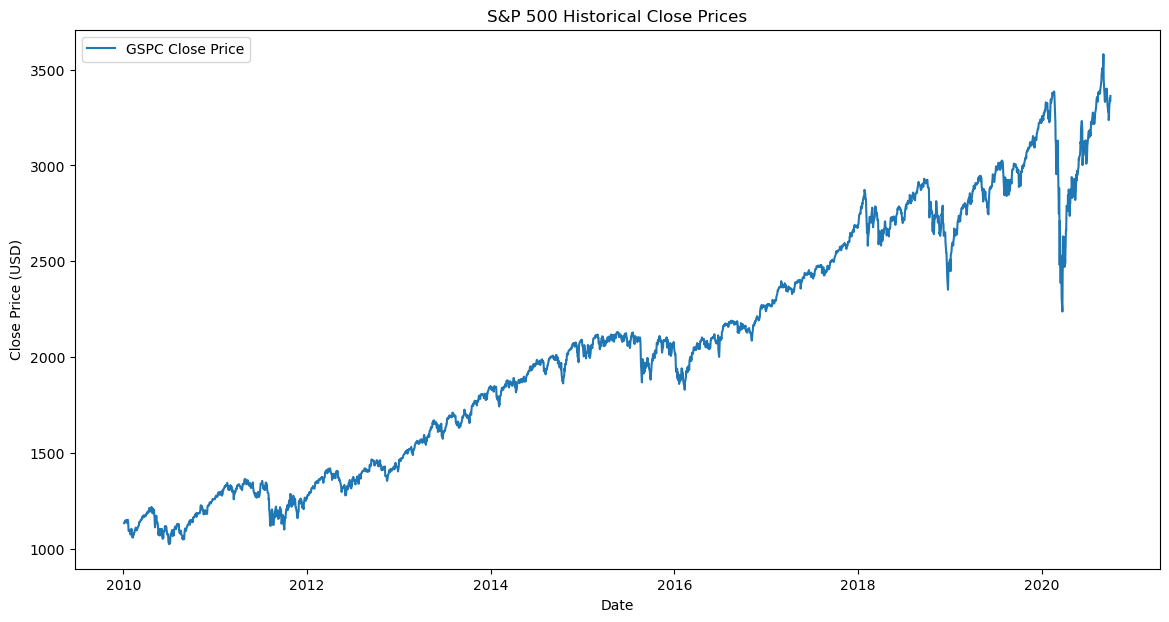

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(GSPC_values['Close'], label='GSPC Close Price')
plt.title('S&P 500 Historical Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

Create our train and test data

In [13]:
GSPC_values.index = pd.to_datetime(GSPC_values.index)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
GSPC_values['Close'] = scaler.fit_transform(GSPC_values[['Close']])

train_data = GSPC_values.query('Date<"2019-01-01"').reset_index(drop=False)
test_data = GSPC_values.query('Date>="2019-01-01"').reset_index(drop=False)

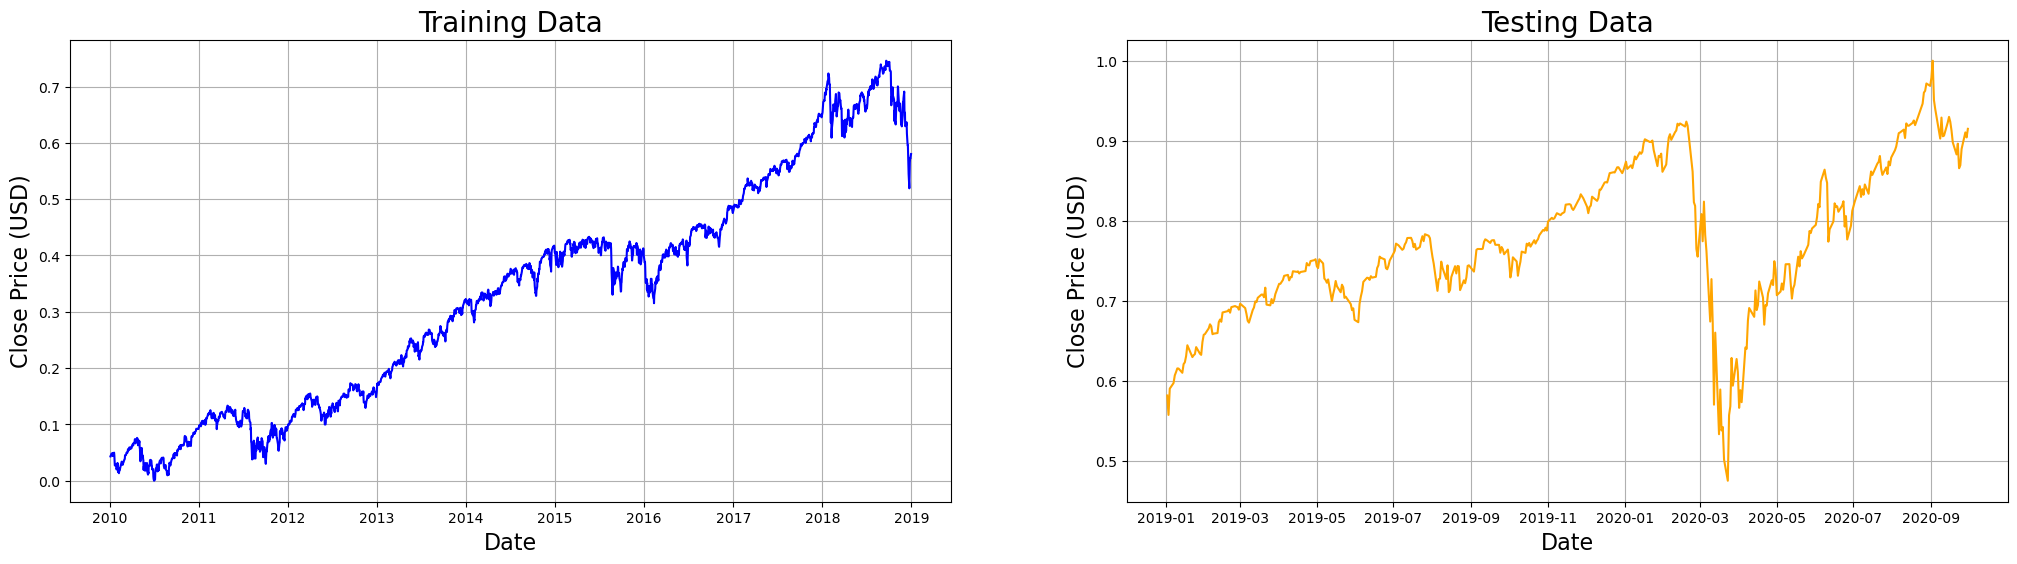

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
ax1.plot(train_data['Date'], train_data['Close'], color='blue')
ax1.set_title('Training Data', fontsize=20)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Close Price (USD)', fontsize=16)  
ax1.grid()
ax2.plot(test_data['Date'], test_data['Close'], color='orange')
ax2.set_title('Testing Data', fontsize=20)
ax2.set_xlabel('Date', fontsize=16)
ax2.set_ylabel('Close Price (USD)', fontsize=16)  
ax2.grid()
plt.show()

Build the LSTM neural network

In [15]:
X_train = train_data.Date
y_train = train_data['Close']

X_test = test_data.Date
y_test = test_data['Close']

n_features = 1

train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))

In [16]:
from tensorflow import keras

look_back = 20

train_generator = keras.preprocessing.sequence.TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = keras.preprocessing.sequence.TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

n_neurons  = 4
model = keras.models.Sequential()
model.add(keras.layers.LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(train_generator,epochs=300, verbose=2)

Epoch 1/300


c:\Users\David\miniconda3\envs\david\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\David\miniconda3\envs\david\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 - 1s - 5ms/step - loss: 0.0056
Epoch 2/300
225/225 - 0s - 2ms/step - loss: 4.8359e-04
Epoch 3/300
225/225 - 0s - 2ms/step - loss: 2.3364e-04
Epoch 4/300
225/225 - 0s - 2ms/step - loss: 1.5548e-04
Epoch 5/300
225/225 - 0s - 2ms/step - loss: 1.4325e-04
Epoch 6/300
225/225 - 0s - 2ms/step - loss: 1.5348e-04
Epoch 7/300
225/225 - 0s - 2ms/step - loss: 1.4307e-04
Epoch 8/300
225/225 - 0s - 2ms/step - loss: 1.3260e-04
Epoch 9/300
225/225 - 0s - 2ms/step - loss: 1.2913e-04
Epoch 10/300
225/225 - 0s - 2ms/step - loss: 1.2386e-04
Epoch 11/300
225/225 - 0s - 2ms/step - loss: 1.2647e-04
Epoch 12/300
225/225 - 0s - 2ms/step - loss: 1.2511e-04
Epoch 13/300
225/225 - 0s - 2ms/step - loss: 1.1994e-04
Epoch 14/300
225/225 - 0s - 2ms/step - loss: 1.2483e-04
Epoch 15/300
225/225 - 0s - 2ms/step - loss: 1.2886e-04
Epoch 16/300
225/225 - 0s - 2ms/step - loss: 1.2691e-04
Epoch 17/300
225/225 - 0s - 2ms/step - loss: 1.1218e-04
Epoch 18/300
225/225 - 0s - 2ms/step - loss: 1.1017e-04
Epoch 19/300
225/

In [17]:
test_predictions  = model.predict(test_generator)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


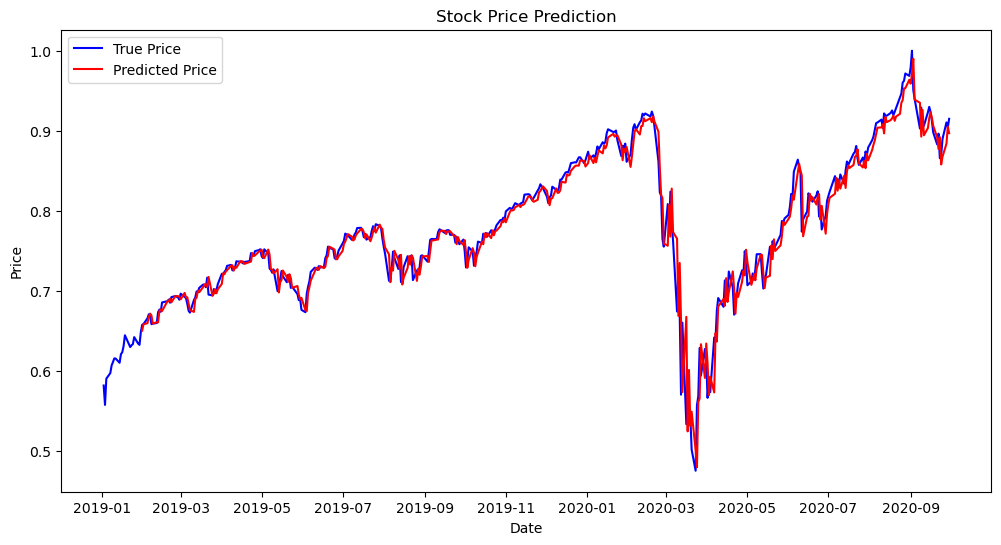

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.Date,test_data['Close'], label='True Price', color='blue')
plt.plot(test_data.Date[20:], test_predictions, label='Predicted Price', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()